In [2]:
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from statsmodels.tsa.ar_model import AR
from statsmodels.api import OLS
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from datetime import date, datetime, timedelta
import sys
import warnings

def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

# Generating non-stationary time series

In [30]:
data = pd.DataFrame(perdelta(date(2008, 1, 1), date(2018, 1, 31), timedelta(days = 1)), columns = ['date'])
data['time_index'] = data.index

data["yearmonth"] = data["date"].apply(lambda d: d.month)
data["monthday"] = data["date"].apply(lambda d: d.day)
data["weekday"] = data["date"].apply(lambda d: int(d.strftime("%w")))

data = data.set_index('date')

# Train/test split = 90%
split_index = int(0.9*len(data.index)) 

### Autoregression model AR 1

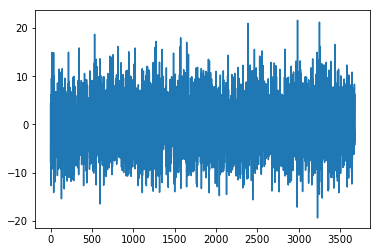

In [31]:
Init_value = 0
c0 = 0
c1 = -0.5
sigma = 5

y_clean = [Init_value]
for i in range(len(data.index)):
    y_clean.append(c0 + c1*y_clean[-1] + sigma*np.random.randn(1)[0])

data['y_clean'] = y_clean[1:]
    
plt.plot(data['time_index'], data['y_clean'])
plt.show()

### Non-linear deterministic trend

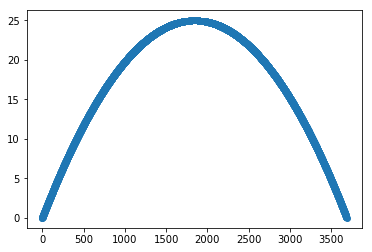

In [32]:
trend_scale = (c0/(1-c1) + 5*sigma)

def trend_shape(t):
    return trend_scale*(1 - 4*(t/len(data.index) - 0.5)**2)

data['trend'] = data['time_index'].apply(trend_shape)

plt.scatter(data['time_index'], data['trend'])
plt.show()

### Monthly and daily multiplicative seasonality

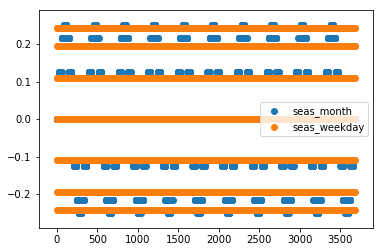

In [33]:
data["seas_yearmonth"] = 0.25 * np.sin((2*np.pi / 12) * (data['yearmonth']-1))
data["seas_weekday"] = 0.25 * np.sin((2*np.pi / 7) * data['weekday'])

plt.scatter(data['time_index'], data['seas_yearmonth'], label='seas_month')
plt.scatter(data['time_index'], data['seas_weekday'], label='seas_weekday')
plt.legend()
plt.show()

### Resulting time series

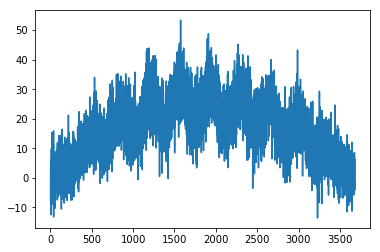

In [34]:
data["y"] = data['trend'] + data['trend']*data['seas_yearmonth'] + data['trend']*data['seas_weekday'] + data["y_clean"]
data["dy"] = data["y"] - data["y"].shift(1)
data.dropna(inplace=True)

plt.plot(data['time_index'], data['y'])
plt.show()

# Econometric approach: testing various specifications of linear model

### AR 1 model

In [35]:
data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

In [36]:
estm = AR(data_train["y"]).fit(maxlag = 1)

const = estm.params['const']
coef = estm.params['L1.y']
print ("intercept: ", const, ", coef: ", coef)

y_pred = const + coef * data_test["y"].shift(1)[1:]
y_true = data_test["y"][1:]
score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)

intercept:  9.54349087 , coef:  0.470260424163
MSE on the test dataset is 99.950.


### AR 1 model with differencing

In [37]:
estm = AR(data_train["dy"]).fit(maxlag = 1)

const = estm.params['const']
coef = estm.params['L1.dy']
print ("intercept: ", const, ", coef: ", coef)

y_pred = const + coef * data_test["dy"].shift(1)[1:]
y_true = data_test["dy"][1:]
score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)

intercept:  0.00609436295779 , coef:  -0.626295448373
MSE on the test dataset is 43.475.


### AR 1 model with differencing and seasonality

In [38]:
Dummies = pd.get_dummies(100*data["yearmonth"]+data["weekday"]).add_prefix('seas_').iloc[:,1:]

Dummies_train = Dummies.iloc[:split_index]
Dummies_test = Dummies.iloc[split_index:]

In [39]:
exog = add_constant(pd.DataFrame(data_train["dy"].shift(1)).join(Dummies_train))
endog = data_train["dy"]
estm = OLS(endog = endog, exog = exog, missing = 'drop', hasconst = True).fit()

print ("intercept: ", estm.params['const'], ", coef: ", estm.params['dy'])

y_pred = estm.predict(add_constant(pd.DataFrame(data_test["dy"].shift(1)).join(Dummies_test)))[1:]
y_true = data_test["dy"][1:]
score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)

intercept:  3.67336605983 , coef:  -0.723266216005
MSE on the test dataset is 55.441.


### AR 1 model with monthly MA trend and additive seasonality

In [40]:
MA_len = 30
data['y_MA'] = data['y'].rolling(window=MA_len).mean()

data_train = data.iloc[MA_len-1 : split_index]
data_test = data.iloc[split_index : ]

Dummies_train = Dummies.iloc[MA_len-1 : split_index]
Dummies_test = Dummies.iloc[split_index : ]

In [41]:
exog = add_constant(pd.DataFrame(data_train[["y","y_MA"]].shift(1)).join(Dummies_train))
endog = data_train["y"]
estm = OLS(endog = endog, exog = exog, missing = 'drop', hasconst = True).fit()

print ("intercept: ", estm.params['const'], ", coef: ", estm.params['y'])

y_pred = estm.predict(add_constant(pd.DataFrame(data_test[["y","y_MA"]].shift(1)).join(Dummies_test)))[1:]
y_true = data_test["y"][1:]
score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)

intercept:  0.860223189976 , coef:  -0.442855155467
MSE on the test dataset is 37.419.


### AR 1 model with monthly MA trend and multiplicative seasonality - TRUE SPECIFICATION

intercept:  0.710091042279 , coef:  -0.48624145123


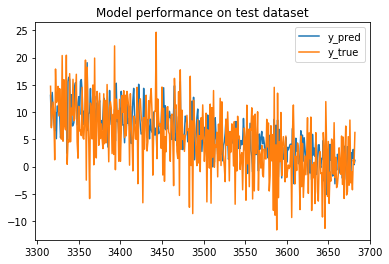

MSE on the test dataset is 26.259.


In [42]:
exog = add_constant(data_train[["y","y_MA"]].shift(1).join(Dummies_train.mul(data_train["y_MA"].shift(1), axis=0)))
endog = data_train["y"]
estm = OLS(endog = endog, exog = exog, missing = 'drop', hasconst = True).fit()

print ("intercept: ", estm.params['const'], ", coef: ", estm.params['y'])

y_pred = estm.predict(add_constant(
        data_test[["y","y_MA"]].shift(1).join(Dummies_test.mul(data_test["y_MA"].shift(1), axis=0))))[1:]
y_true = data_test["y"][1:]

plt.title('Model performance on test dataset')
plt.plot(data_test['time_index'][1:], y_pred, label='y_pred')
plt.plot(data_test['time_index'][1:], y_true, label='y_true')
plt.legend()
plt.show()

score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)

# Machine learning approach: fitting non-linear models with cross-validation

In [43]:
CV_splits = 50

### Step 1. Kernel regression for trend

Grid MSE scores on development set:
-61.010 (+/-37.435) for {'gamma': 1.1e-07}
-61.009 (+/-37.412) for {'gamma': 1.125e-07}
-61.010 (+/-37.397) for {'gamma': 1.15e-07}
-61.012 (+/-37.391) for {'gamma': 1.175e-07}
-61.016 (+/-37.392) for {'gamma': 1.2e-07}

Best MSE score is -61.009. Best parameters set found on development set:
{'gamma': 1.125e-07}


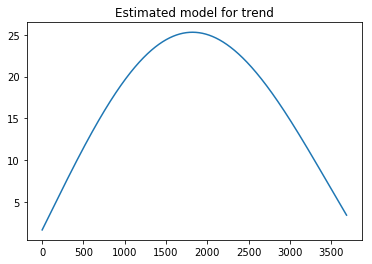

In [44]:
data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

estm_s1 = KernelRidge(kernel = 'rbf')
tuned_parameters = [{'gamma': [1.1e-7, 1.125e-7, 1.15e-7, 1.175e-7, 1.2e-7]}]


grid = GridSearchCV(estimator=estm_s1, param_grid=tuned_parameters,
                   cv=TimeSeriesSplit(n_splits=CV_splits), scoring="neg_mean_squared_error")
grid.fit(data_train['time_index'].values.reshape(-1, 1), data_train['y'].values)

print("Grid MSE scores on development set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, 2 * std, params))
print()
print("Best MSE score is %0.3f." % grid.best_score_, "Best parameters set found on development set:")
print(grid.best_params_)

estm_s1.set_params(**grid.best_params_)
estm_s1.fit(data_train['time_index'].values.reshape(-1, 1), data_train["y"].values)


plt.title('Estimated model for trend')
plt.plot(data['time_index'], estm_s1.predict(data['time_index'].values.reshape(-1, 1)))
plt.show()

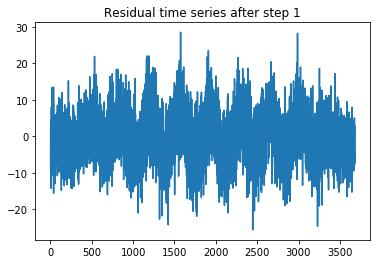

In [45]:
data['trend_est'] = estm_s1.predict(data['time_index'].values.reshape(-1, 1))
data['y_res1'] = data['y'] - data['trend_est']

plt.title('Residual time series after step 1')
plt.plot(data['time_index'], data['y_res1'])
plt.show()

### Step 2. Gradient boosting regression for seasonality

Grid MSE scores on development set:
-38.935 (+/-21.971) for {'n_estimators': 40}
-38.764 (+/-22.769) for {'n_estimators': 45}
-38.763 (+/-23.502) for {'n_estimators': 50}
-38.942 (+/-25.934) for {'n_estimators': 55}
-39.058 (+/-26.470) for {'n_estimators': 60}

Best MSE score is -38.763. Best parameters set found on development set:
{'n_estimators': 50}


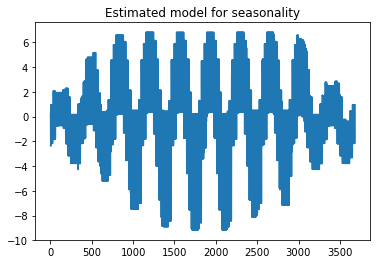

In [72]:
# Restrict number of trees to prevent overfitting

param = ['trend_est', 'monthday', 'yearmonth', 'weekday']

data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

estm_s2 = GradientBoostingRegressor(learning_rate = 0.05, max_features = 'auto', max_depth = len(param)-1)
tuned_parameters = [{'n_estimators': [40, 45, 50, 55, 60]}]


grid = GridSearchCV(estimator=estm_s2, param_grid=tuned_parameters,
                   cv=TimeSeriesSplit(n_splits=CV_splits), scoring="neg_mean_squared_error")
grid.fit(data_train[param], data_train['y_res1'])

print("Grid MSE scores on development set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, 2 * std, params))
print()
print("Best MSE score is %0.3f." % grid.best_score_, "Best parameters set found on development set:")
print(grid.best_params_)

estm_s2.set_params(**grid.best_params_)
estm_s2.fit(data_train[param], data_train['y_res1'])


plt.title('Estimated model for seasonality')
plt.plot(data['time_index'], estm_s2.predict(data[param]))
plt.show()

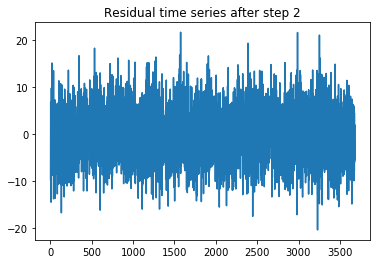

In [73]:
data['seas_est'] = estm_s2.predict(data[param])
data['y_res2'] = data['y_res1'] - data['seas_est']

plt.title('Residual time series after step 2')
plt.plot(data['time_index'], data['y_res2'])
plt.show()

### Step 3. ARIMA model for residual fluctuations

In [74]:
data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

estm_s3 = AR(data_train["y_res2"]).fit(maxlag = 1)

const = estm_s3.params['const']
coef = estm_s3.params['L1.y_res2']
print ("intercept: ", const, ", coef: ", coef)

intercept:  0.00284131335591 , coef:  -0.43062473674


### Step 4. Combining all machine learning models together

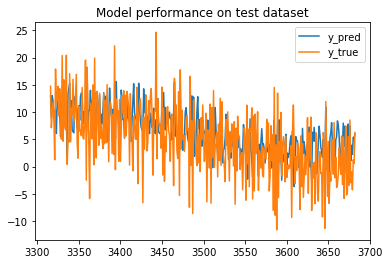

MSE on the test dataset is 27.707.


In [75]:
y_res2_pred = const + coef * data_test["y_res2"].shift(1)[1:]
y_res1_pred = y_res2_pred + estm_s2.predict(data_test[param])[1:]
y_pred = y_res1_pred + estm_s1.predict(data_test['time_index'].values.reshape(-1, 1))[1:]
y_true = data_test["y"][1:]

plt.title('Model performance on test dataset')
plt.plot(data_test['time_index'][1:], y_pred, label='y_pred')
plt.plot(data_test['time_index'][1:], y_true, label='y_true')
plt.legend()
plt.show()

score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)

# Representation learning from ML methods

### Approximate trend shape with basis functions

In [76]:
def gen_basis_functions(arg, order_low, order_high):
    output = {}
    for i in range(order_low, order_high+1):
        output['x^' + str(i)] = np.power(arg, i)
    return output

In [78]:
X = pd.DataFrame(gen_basis_functions(data['time_index'].astype(float), -5, 5))
y = data['trend_est']

OLS_reg = OLS(endog = y, exog = X, missing = 'drop', hasconst = True).fit_regularized(alpha=1, L1_wt=1, refit=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print (OLS_reg.summary())

                            OLS Regression Results                            
Dep. Variable:              trend_est   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 2.949e+04
Date:                Fri, 23 Feb 2018   Prob (F-statistic):               0.00
Time:                        13:16:52   Log-Likelihood:                -7209.3
No. Observations:                3682   AIC:                         1.442e+04
Df Residuals:                    3679   BIC:                         1.444e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x^-1                0          0        nan        n

##### Trend can be described by second order polynom of time_index

### Importance of seasonal features in GB forest

In [79]:
for i in range(len(param)):
    print (param[i] + " - " + str(np.round(estm_s2.feature_importances_[i], 2)))    

trend_est - 0.18
monthday - 0.0
yearmonth - 0.41
weekday - 0.41


##### Feature "monthday" can be dropped

### Interaction of features

In [100]:
discretization_steps = 100
Vars_discretized = {}
Vars_discretized['trend_est'] = np.arange(data['trend_est'].min(), data['trend_est'].max(), 
                    (1/discretization_steps) * (data['trend_est'].max() - data['trend_est'].min()))
Vars_discretized['monthday'] = np.arange(data['monthday'].min(), data['monthday'].max(), 1)
Vars_discretized['yearmonth'] = np.arange(data['yearmonth'].min(), data['yearmonth'].max(), 1)
Vars_discretized['weekday'] = np.arange(data['weekday'].min(), data['weekday'].max(), 1)

def int_plot_3d(X, Y, free_vars, angle):
    free_vals = []
    for fv in range(len(free_vars)):
        free_vals.append(random.choice(Vars_discretized[free_vars[fv]]))

    pred_vals = []
    for i in Vars_discretized[Y]:
        cur_line = []
        for j in Vars_discretized[X]:
            cur_feat = len(param)*[0]
            cur_feat[param.index(X)] = j
            cur_feat[param.index(Y)] = i
            for fv in range(len(free_vars)):
                cur_feat[param.index(free_vars[fv])] = free_vals[fv]     
            cur_feat = np.array(cur_feat).reshape(1, -1)
            cur_line.append(estm_s2.predict(cur_feat)[0])
        pred_vals.append(np.array(cur_line))
    pred_vals = np.array(pred_vals)

    plt_X, plt_Y = np.meshgrid(Vars_discretized[X], Vars_discretized[Y])
   
    fig = plt.figure(figsize=(10, 6))
    ax = fig.gca(projection = '3d')
    ax.view_init(azim = angle)
    surf = ax.plot_surface(plt_X, plt_Y, pred_vals, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    plt.xlabel(X)
    plt.ylabel(Y)
    plt.tight_layout()
    plt.show()

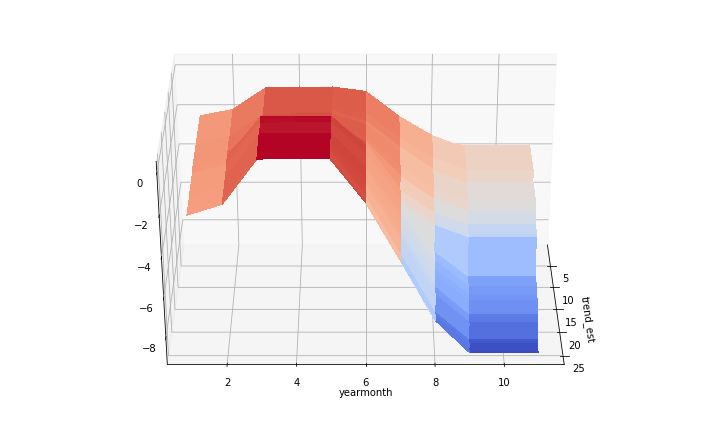

In [127]:
X = 'trend_est'
Y = 'yearmonth'
free_vars = ['weekday', 'monthday']

angle = 0
int_plot_3d(X, Y, free_vars, angle)

##### Strong interaction on all levels - the curve significantly changes shape in all projections

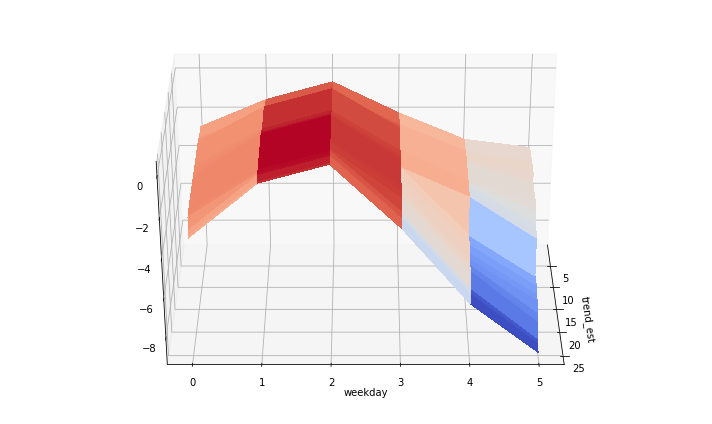

In [134]:
X = 'trend_est'
Y = 'weekday'
free_vars = ['yearmonth', 'monthday']

angle = 0
int_plot_3d(X, Y, free_vars, angle)

##### Strong interaction on all levels - the curve significantly changes shape in all projections

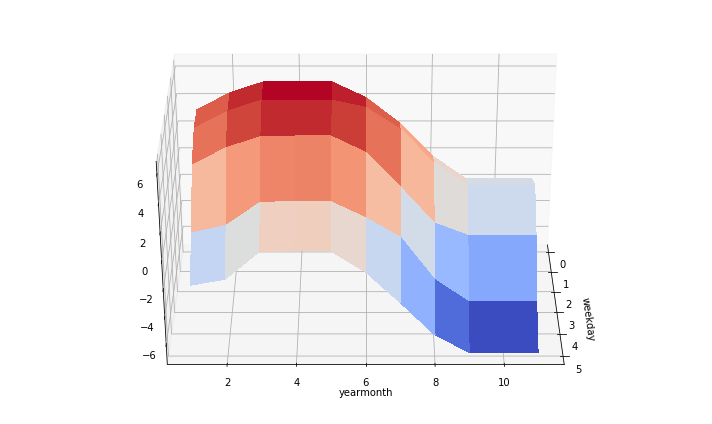

In [138]:
Y = 'yearmonth'
X = 'weekday'
free_vars = ['trend_est', 'monthday']

angle = 0
int_plot_3d(X, Y, free_vars, angle)

##### No interactions - projections only differ by parallel shift

# Conclusion

### The given time series can be described as:

##### y = trend + yearmonth + weekday + trend\*yearmonth + trend\*weekday + AR(1), where trend = (1 + time_index + time_index^2)